## Load BioMed-CLIP model

In [ ]:
import json

from urllib.request import urlopen
from PIL import Image
import torch
from huggingface_hub import hf_hub_download
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS


# Download the model and config files
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_pytorch_model.bin",
    local_dir="checkpoints"
)
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_config.json",
    local_dir="checkpoints"
)


# Load the model and config files 
model_name = "biomedclip_local"

with open("checkpoints/open_clip_config.json", "r") as f:
    config = json.load(f)
    model_cfg = config["model_cfg"]
    preprocess_cfg = config["preprocess_cfg"]


if (not model_name.startswith(HF_HUB_PREFIX)
    and model_name not in _MODEL_CONFIGS
    and config is not None):
    _MODEL_CONFIGS[model_name] = model_cfg

tokenizer = get_tokenizer(model_name)

model, _, preprocess = create_model_and_transforms(
    model_name=model_name,
    pretrained="checkpoints/open_clip_pytorch_model.bin",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()},
)


In [15]:
model

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
## Dataloader

In [ ]:
from torchvision import transforms
import random
from collections import defaultdict
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from PIL import Image
import torch

class FewShotImageFolder(Dataset):
    def __init__(self, root, num_shots, transform=None, test_transform=None, seed=42):
        super().__init__()
        self.root = root
        self.num_shots = num_shots
        self.transform = transform
        self.test_transform = test_transform
        
        full_dataset = ImageFolder(root)
        self.class_to_idx = full_dataset.class_to_idx

        label_to_samples = defaultdict(list)
        for path, label in full_dataset.samples:
            label_to_samples[label].append(path)
        
        random.seed(seed)
        
        self.train_samples = []
        self.train_targets = []
        self.test_samples = []
        self.test_targets = []

        for label, samples in label_to_samples.items():
            if len(samples) <= num_shots:
                sampled = samples
                remain = []
            else:
                sampled = random.sample(samples, num_shots)
                remain = [s for s in samples if s not in sampled]

            self.train_samples.extend(sampled)
            self.train_targets.extend([label] * len(sampled))
            self.test_samples.extend(remain)
            self.test_targets.extend([label] * len(remain))

        combined = list(zip(self.train_samples, self.train_targets))
        random.shuffle(combined)
        self.samples, self.targets = zip(*combined)
        self.samples = list(self.samples)
        self.targets = list(self.targets)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path = self.samples[idx]
        label = self.targets[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label

    def get_test_set(self):
        return SimpleImageDataset(self.test_samples, self.test_targets,self.test_transform)


class SimpleImageDataset(Dataset):
    def __init__(self, samples, targets, transform):
        self.samples = samples
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        label = self.targets[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label

In [17]:
model.logit_scale.exp()

tensor(85.2323, grad_fn=<ExpBackward0>)

In [ ]:
# from dataset.dataset import Chestxray14_Dataset
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" 
# Basic transform compatible with CLIP input size & normalization
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),           
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),       
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])

dataset_root = r'D:\MedicalVLMs\data\Chest X-Ray Images (Pneumonia)'

fewshot_dataset = FewShotImageFolder(root=dataset_root, num_shots=16, transform=test_transform, test_transform = test_transform, seed=1111)

from torch.utils.data import DataLoader
train_loader = DataLoader(fewshot_dataset, batch_size=32, shuffle=True)

test_dataset = fewshot_dataset.get_test_set()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(fewshot_dataset)}")
print(f"Test size: {len(test_dataset)}")



idx_to_folder = {v: k for k, v in fewshot_dataset.class_to_idx.items()}
class_names = [folder_name for idx, folder_name in sorted(idx_to_folder.items())]
print(class_names)
num_classes = len(class_names)

model.to(device)
# prompt_templates = [
#         "a photo of {}",
#         "{} presented in image",
#     ]
# prompt_templates = [
#         "a photo of chest X-ray showing {}",
#         "a chest X-ray showing {}.",
#         "evidence of {} in lungs",
#         "radiographic signs of {}.",
#         "{} presented in image.",
#         "a patient diagnosed with {} in chest X-ray."
#     ]
prompt_templates = [
    "a photo of {}",
    "a chest X-ray showing {}",
    "a photo of chest X-ray showing {}",
    "radiographic signs of {}",
    "evidence of {} in lungs",
    "an X-ray of lungs with {}",
    "chest radiograph indicating {}",
    "X-ray scan showing {}",
    "frontal chest X-ray with {}",
    "PA chest X-ray of {}",
    "lateral chest X-ray of {}",
    "radiological appearance of {}",
    "findings consistent with {} in chest X-ray",
    "X-ray showing features of {}",
    "lungs affected by {} in X-ray",
    "an X-ray demonstrating {}",
    "medical imaging revealing {}",
    "an image of chest radiograph showing {}",
    "a patient chest X-ray showing {}",
    "radiograph evidence of {}",
    "radiology scan depicting {}",
    "diagnostic chest X-ray of {}",
    "projection X-ray showing {}",
    "X-ray report consistent with {}",
    "lungs diagnosed with {} via X-ray"
]

prompts = [template.format(l) for l in class_names for template in prompt_templates]
tokens = tokenizer(prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features.view(len(class_names), len(prompt_templates), -1)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_feats_global = text_features.mean(dim=1)  # prompt ensemble

Train size: 32
Test size: 8450
['COVID', 'Normal']


## Compute equivalent logit scale (For calibration)

In [ ]:
# -------------------------------
# 1️⃣ Collect support logits + compute class-wise bias
# -------------------------------
support_logits_list = []
all_labels_train = []

model.to(device)
prompt_templates = [
        "a photo of chest X-ray showing {}",
        "a chest X-ray showing {}.",
        "evidence of {} in lungs",
        "radiographic signs of {}.",
        "a patient diagnosed with {} in chest X-ray."
    ]
prompts = [template.format(l) for l in class_names for template in prompt_templates]
tokens = tokenizer(prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features.view(len(class_names), len(prompt_templates), -1)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_feats = text_features.mean(dim=1)  # prompt ensemble

with torch.no_grad():
    for images, labels in train_loader:  # few-shot support set
        images = images.to(device)
        labels = labels.to(device)
        all_labels_train.append(labels.cpu())

        # Encode and normalize
        image_feats = model.encode_image(images).float()
        image_feats /= image_feats.norm(dim=-1, keepdim=True)

        text_feats_norm = text_feats.float().to(device)
        # text_feats_norm /= text_feats_norm.norm(dim=-1, keepdim=True)

        # Raw logits
        # logits = image_feats @ text_feats_norm.T
        logits = model.logit_scale.exp() * (image_feats @ text_feats_norm.T)
        support_logits_list.append(logits.cpu())

support_logits = torch.cat(support_logits_list, dim=0)  # [N_train, num_classes]
all_labels_train = torch.cat(all_labels_train, dim=0)

num_classes = support_logits.size(1)

# -------------------------------
# Compute min & max per sample
# -------------------------------
support_logits_min, _ = support_logits.min(dim=1, keepdim=True)
support_logits_max, _ = support_logits.max(dim=1, keepdim=True)

import torch
import torch.nn.functional as F

device = "cuda"

num_classes = support_logits.size(1)

# -------------------------------
# Compute per-class mean & std from support set
# -------------------------------
lZS_mean = torch.zeros(num_classes, device=device)
lZS_std  = torch.zeros(num_classes, device=device)

all_labels_train = []
for _, labels in train_loader:
    all_labels_train.append(labels)
all_labels_train = torch.cat(all_labels_train).to(device)

support_logits = support_logits.to(device) 
for c in range(num_classes):
    mask = (all_labels_train == c)
    if mask.sum() == 0:
        lZS_mean[c] = 0.0
        lZS_std[c]  = 1.0
    else:
        class_logits = support_logits[mask, c]
        lZS_mean[c] = class_logits.mean()
        lZS_std[c]  = class_logits.std().clamp(min=1e-6)

# -------------------------------
# Compute equivalent logit_scale
# -------------------------------
# orig_logit_scale = model.logit_scale.exp().item()
orig_logit_scale = 85
mean_sigma = lZS_std.mean().item()   # 可以用平均 std 作为整体缩放参考
equiv_logit_scale = orig_logit_scale / mean_sigma

print(f"Original logit_scale: {orig_logit_scale:.3f}")
print(f"Equivalent logit_scale from class-wise z-score: {equiv_logit_scale:.3f}")

Original logit_scale: 85.000
Equivalent logit_scale from class-wise z-score: 41.419


## Training-free Inter-class Logit Adaptation (TILA)

In [ ]:
layers = [5,7,9,11] ## Features from which layers

weights = torch.tensor([0.25, 0.25, 0.25, 0.25]) ## Weights for different layers, equal by default
weights = (weights / weights.sum()).to(device)

equiv_logit_scale = equiv_logit_scale 
# layers = [1,3,9,11]
a = 0.1  ## zero-shot logits weight for Logits fusion

all_labels, all_logits, all_probs, all_preds = [], [], [], []

4


In [ ]:
## extract multiple features (cache)

def extract_image_features(model, images, layers=[5,7,9,11]):
    """
    Extract CLS token from intermediate layers of model.encode_image
    while keeping the forward exactly the same.
    """

    features = {}
    hooks = []

    # define hook for each block inside encode_image
    def get_hook(idx):
        def hook(module, input, output):
            cls_token = output[:, 0]  # CLS token
            features[idx] = cls_token
        return hook

    # register hooks on the blocks of the trunk used in encode_image
    trunk = model.visual.trunk
    for idx in layers:
        h = trunk.blocks[idx].register_forward_hook(get_hook(idx))
        hooks.append(h)
        # if idx != 11:
        #     h = trunk.blocks[idx].register_forward_hook(get_hook(idx))
        #     hooks.append(h)

    # forward through encode_image
    final_feature = model.encode_image(images)

    # remove hooks
    for h in hooks:
        h.remove()

    # collect features in order
    feat_list = [features[idx] for idx in layers]
    # feat_list = []
    # for idx in layers:
    #     if idx == 11:
    #         feat_list.append(final_feature)  # final layer uses projection feature
    #     else:
    #         feat_list.append(features[idx])  # intermediate CLS tokens

    return feat_list  # list of [B, embed_dim]

model.to(device)
model.eval()
cache_keys_layers = []  # for each: [num_classes, embed_dim]
cache_values_layers = []  # for each: [num_classes, num_classes]

with torch.no_grad():
    for layer in layers:
        class_feats = defaultdict(list)
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            feats =  extract_image_features(model,images, layers=[layer])[0]  # [B, embed_dim]
            feats = F.normalize(feats, dim=-1)
            for i, label in enumerate(labels):
                class_feats[label.item()].append(feats[i])
        
        keys, values = [], []
        num_classes = len(class_feats)
        for c in range(num_classes):
            feats_c = torch.stack(class_feats[c], dim=0)
            proto_c = feats_c.mean(dim=0)
            proto_c = F.normalize(proto_c, dim=-1)
            keys.append(proto_c)
            onehot = F.one_hot(torch.tensor(c), num_classes=num_classes).float()
            values.append(onehot)
        
        cache_keys_layers.append(torch.stack(keys).to(device))
        cache_values_layers.append(torch.stack(values).to(device))

print(len(cache_keys_layers))

In [ ]:
## Build Text Features and weighting prompt ensembles using image features (optional)
def build_multilayer_adapted_text_features(text_features, cache_keys_layers, beta=20.0, weights=None): 
    """
    text_features: [num_classes, num_prompts, feat_dim]
    cache_keys_layers: list of RobustPrototype objects, one per layer
    beta: softmax temperature for weighting prompts
    weights: list of floats for layer fusion, length = num_layers
    """
    num_classes, num_prompts, feat_dim = text_features.shape
    num_layers = len(cache_keys_layers)

    if weights is None:
        weights = [1.0 / num_layers] * num_layers

    adapted_text_feats = torch.zeros(num_classes, feat_dim, device=text_features.device)

    for c in range(num_classes):
        feats_c = F.normalize(text_features[c], dim=-1)   # [num_prompts, feat_dim]

        # For each layer, compute similarity between prototypes and text prompts
        layer_weighted = []
        for l, rp in enumerate(cache_keys_layers):
            proto_c = rp.get_prototypes()[c].unsqueeze(0)   # [1, feat_dim]
            sim = (feats_c @ proto_c.T).squeeze(-1)         # [num_prompts]
            w = torch.softmax(beta * sim, dim=0)            # prompt weights
            proto_text = (w.unsqueeze(1) * feats_c).sum(dim=0)
            layer_weighted.append(weights[l] * proto_text)

        # Fuse across layers
        fused_proto = torch.stack(layer_weighted, dim=0).sum(dim=0)
        adapted_text_feats[c] = F.normalize(fused_proto, dim=-1)

    return adapted_text_feats


# ------------------ Compute Multi-layer Adapted Text Features ------------------
with torch.no_grad():
    tokens = tokenizer(prompts).to(device)
    text_features = model.encode_text(tokens)
    text_features = text_features.view(len(class_names), len(prompt_templates), -1)
    text_features = F.normalize(text_features, dim=-1)

    # Now update text features using multi-layer robust prototypes
    text_feats_global = build_multilayer_adapted_text_features(
        text_features, cache_keys_layers, beta=20.0,
        weights=[0.25, 0.25, 0.25, 0.25]   # same as used in fusion
    )


In [ ]:
## Inference

beta = 10 ## Fixed

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        layer_feats = extract_image_features(model,images, layers=layers)
        layer_logits = []
        for idx, feats in enumerate(layer_feats):
            feats = F.normalize(feats, dim=-1)
            affinity = feats @ cache_keys_layers[idx].T  # [B, num_classes]
            cache_logits = ((-1) * (beta - beta * affinity)).exp() @ cache_values_layers[idx]
            layer_logits.append(cache_logits)
        
        tip_logits = sum(layer_logits) / len(layer_logits)
        tip_logits = sum(w * l for w, l in zip(weights, layer_logits))
                
        clip_feats = model.encode_image(images)
        clip_feats = F.normalize(clip_feats, dim=-1)
        clip_logits = clip_feats @ text_feats_global.T

        tip_logits = equiv_logit_scale * (a * clip_logits +(1-a) * tip_logits) / 2

        clip_logits = clip_logits * equiv_logit_scale
        clip_mean = clip_logits.mean(dim=1, keepdim=True)
        clip_std = clip_logits.std(dim=1, keepdim=True) + 1e-6
        tip_mean = tip_logits.mean(dim=1, keepdim=True)
        tip_std = tip_logits.std(dim=1, keepdim=True) + 1e-6
        tip_logits = ((tip_logits - tip_mean) / tip_std) * clip_std + clip_mean

        probs = F.softmax(tip_logits, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(labels.cpu())
        all_logits.append(tip_logits.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

# Convert to numpy
all_labels = torch.cat(all_labels).numpy()
all_logits = torch.cat(all_logits).numpy()
all_probs = torch.cat(all_probs).numpy()
all_preds = torch.cat(all_preds).numpy()

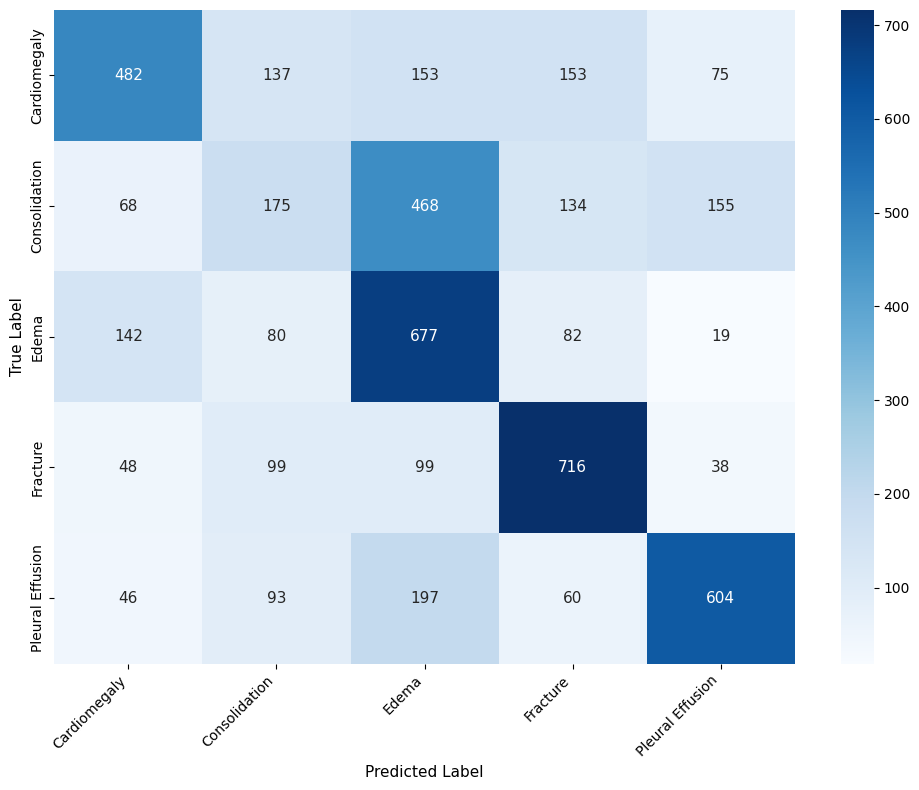

Class Cardiomegaly: AUROC = 0.8269
Class Consolidation: AUROC = 0.5861
Class Edema: AUROC = 0.7849
Class Fracture: AUROC = 0.8807
Class Pleural Effusion: AUROC = 0.8450
Averaged AUROC: 0.7847
Test set accuracy: 0.5308
Class Cardiomegaly: Accuracy = 0.4820
Class Consolidation: Accuracy = 0.1750
Class Edema: Accuracy = 0.6770
Class Fracture: Accuracy = 0.7160
Class Pleural Effusion: Accuracy = 0.6040
Average per-class accuracy: 0.5308
F1-macro: 0.5178
F1-weighted: 0.5178
F1-micro: 0.5308
Class Cardiomegaly: F1 = 0.5398
Class Consolidation: F1 = 0.2210
Class Edema: F1 = 0.5220
Class Fracture: F1 = 0.6676
Class Pleural Effusion: F1 = 0.6388

Classification Report:
                  precision    recall  f1-score   support

    Cardiomegaly     0.6132    0.4820    0.5398      1000
   Consolidation     0.2997    0.1750    0.2210      1000
           Edema     0.4247    0.6770    0.5220      1000
        Fracture     0.6253    0.7160    0.6676      1000
Pleural Effusion     0.6779    0.6040   

In [ ]:
## print results

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 11})
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
# plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === AUROC ===
num_classes = len(class_names)
try:
    onehot_labels = F.one_hot(torch.tensor(all_labels), num_classes=num_classes).numpy()
    aucs = roc_auc_score(onehot_labels, all_probs, average=None)
    for i, auc in enumerate(aucs):
        print(f"Class {class_names[i]}: AUROC = {auc:.4f}")
    print(f"Averaged AUROC: {aucs.mean():.4f}")
except Exception as e:
    print("Error calculating AUROC:", e)

import numpy as np

# Predicted class
preds = np.argmax(all_probs, axis=1)  # or np.argmax(all_logits, axis=1)

# Compute accuracy
accuracy = (preds == all_labels).mean()

print(f"Test set accuracy: {accuracy:.4f}")

import numpy as np

# Predicted class
preds = np.argmax(all_probs, axis=1)

# Overall accuracy (what you already have)
accuracy = (preds == all_labels).mean()
# === Per-class accuracy ===
num_classes = len(class_names)
per_class_acc = []
for c in range(num_classes):
    # indices of samples belonging to class c
    idx = np.where(np.array(all_labels) == c)[0]
    if len(idx) > 0:
        acc_c = (preds[idx] == np.array(all_labels)[idx]).mean()
    else:
        acc_c = np.nan  # handle case with no samples for class
    per_class_acc.append(acc_c)
    print(f"Class {class_names[c]}: Accuracy = {acc_c:.4f}")

# === Average (balanced) accuracy ===
avg_class_acc = np.nanmean(per_class_acc)
print(f"Average per-class accuracy: {avg_class_acc:.4f}")

from sklearn.metrics import f1_score, classification_report

# === Macro / Weighted F1 ===
f1_macro = f1_score(all_labels, preds, average='macro')
f1_weighted = f1_score(all_labels, preds, average='weighted')
f1_micro = f1_score(all_labels, preds, average='micro')

print(f"F1-macro: {f1_macro:.4f}")
print(f"F1-weighted: {f1_weighted:.4f}")
print(f"F1-micro: {f1_micro:.4f}")

# === Per-class F1 ===
per_class_f1 = f1_score(all_labels, preds, average=None)
for i, f1 in enumerate(per_class_f1):
    print(f"Class {class_names[i]}: F1 = {f1:.4f}")

# === Full classification report (precision/recall/F1) ===
print("\nClassification Report:")
print(classification_report(all_labels, preds, target_names=class_names, digits=4))

## Zero-shot Baseline

In [ ]:
from dataset.dataset import Chestxray14_Dataset
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" 
# Basic transform compatible with CLIP input size & normalization
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),           
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),       
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])

# dataset_root = r'D:\MedicalVLMs\data\RSNA'
# dataset_root = r'D:\MedicalVLMs\data\Tuberculosis Chest X-rays (Shenzhen)'
# dataset_root = r'D:\MedicalVLMs\data\Chest X-Ray Images (Pneumonia)'
# dataset_root = r'D:\MedicalVLMs\data\JSRT nodule'
# dataset_root = r'D:\MedicalVLMs\data\SIIM ACR Pneumothorax'
dataset_root = r'D:\MedicalVLMs\data\Chexpert_5x1000'


fewshot_dataset = FewShotImageFolder(root=dataset_root, num_shots=16, transform=test_transform, test_transform = test_transform, seed=1111)

from torch.utils.data import DataLoader
train_loader = DataLoader(fewshot_dataset, batch_size=32, shuffle=True)

test_dataset = fewshot_dataset.get_test_set()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(fewshot_dataset)}")
print(f"Test size: {len(test_dataset)}")



idx_to_folder = {v: k for k, v in fewshot_dataset.class_to_idx.items()}
class_names = [folder_name for idx, folder_name in sorted(idx_to_folder.items())]
print(class_names)
num_classes = len(class_names)

model.to(device)
# prompt_templates = [
#         "a photo of {}",
#         "{} presented in image",
#     ]
# prompt_templates = [
#         "a photo of chest X-ray showing {}",
#         "a chest X-ray showing {}.",
#         "evidence of {} in lungs",
#         "radiographic signs of {}.",
#         "{} presented in image.",
#         "a patient diagnosed with {} in chest X-ray."
#     ]
prompt_templates = [
    "a photo of {}",
    "a chest X-ray showing {}",
    "a photo of chest X-ray showing {}",
    "radiographic signs of {}",
    "evidence of {} in lungs",
    "an X-ray of lungs with {}",
    "chest radiograph indicating {}",
    "X-ray scan showing {}",
    "frontal chest X-ray with {}",
    "PA chest X-ray of {}",
    "lateral chest X-ray of {}",
    "radiological appearance of {}",
    "findings consistent with {} in chest X-ray",
    "X-ray showing features of {}",
    "lungs affected by {} in X-ray",
    "an X-ray demonstrating {}",
    "medical imaging revealing {}",
    "an image of chest radiograph showing {}",
    "a patient chest X-ray showing {}",
    "radiograph evidence of {}",
    "radiology scan depicting {}",
    "diagnostic chest X-ray of {}",
    "projection X-ray showing {}",
    "X-ray report consistent with {}",
    "lungs diagnosed with {} via X-ray"
]

prompts = [template.format(l) for l in class_names for template in prompt_templates]
tokens = tokenizer(prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features.view(len(class_names), len(prompt_templates), -1)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_feats_global = text_features.mean(dim=1)  # prompt ensemble

Train size: 80
Test size: 5000
['Cardiomegaly', 'Consolidation', 'Edema', 'Fracture', 'Pleural Effusion']


Train size: 80
Test size: 5000
['Cardiomegaly', 'Consolidation', 'Edema', 'Fracture', 'Pleural Effusion']


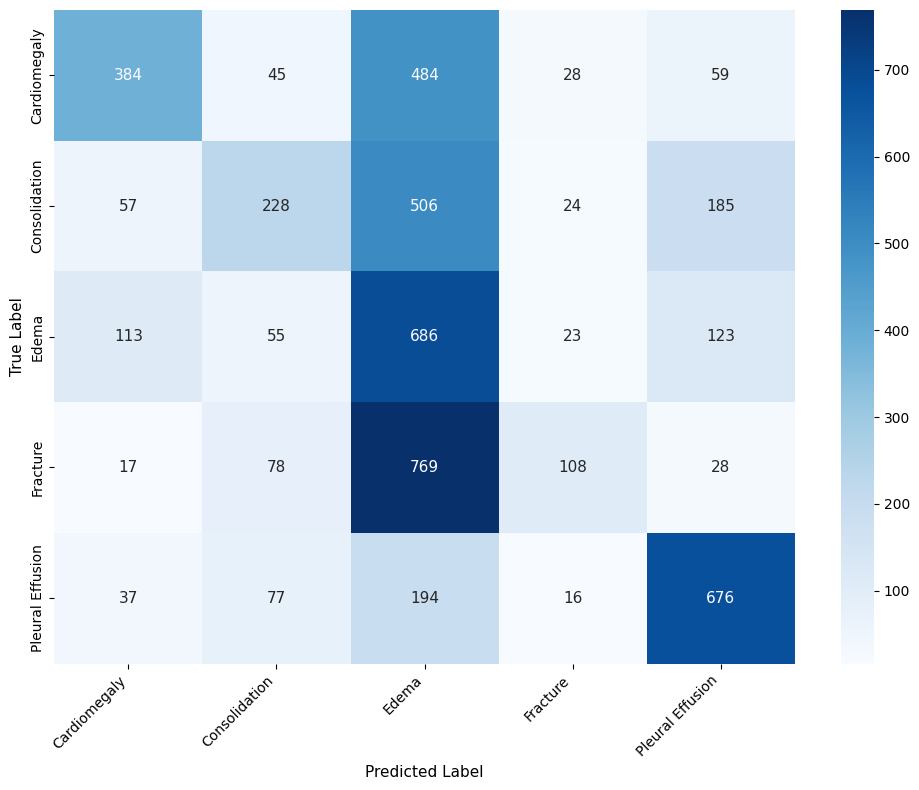

Class Cardiomegaly: AUROC = 0.8119
Class Consolidation: AUROC = 0.6900
Class Edema: AUROC = 0.6416
Class Fracture: AUROC = 0.8108
Class Pleural Effusion: AUROC = 0.8728
Averaged AUROC: 0.7654
Test set accuracy: 0.4164
Class Cardiomegaly: Accuracy = 0.3840
Class Consolidation: Accuracy = 0.2280
Class Edema: Accuracy = 0.6860
Class Fracture: Accuracy = 0.1080
Class Pleural Effusion: Accuracy = 0.6760
Average per-class accuracy: 0.4164
F1-macro: 0.3990
F1-weighted: 0.3990
F1-micro: 0.4164
Class Cardiomegaly: F1 = 0.4776
Class Consolidation: F1 = 0.3075
Class Edema: F1 = 0.3770
Class Fracture: F1 = 0.1802
Class Pleural Effusion: F1 = 0.6528

Classification Report:
                  precision    recall  f1-score   support

    Cardiomegaly     0.6316    0.3840    0.4776      1000
   Consolidation     0.4720    0.2280    0.3075      1000
           Edema     0.2599    0.6860    0.3770      1000
        Fracture     0.5427    0.1080    0.1802      1000
Pleural Effusion     0.6312    0.6760   

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

device = "cuda" if torch.cuda.is_available() else "cpu"

all_labels, all_logits, all_probs = [], [], []
all_preds = []

device = "cuda" 
# Basic transform compatible with CLIP input size & normalization
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),           
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),       
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])

# dataset_root = r'D:\MedicalVLMs\data\Sampled_CXR_1016'

fewshot_dataset = FewShotImageFolder(root=dataset_root, num_shots=16, transform=transform, test_transform = test_transform, seed=2024)
test_dataset = fewshot_dataset.get_test_set()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(fewshot_dataset)}")
print(f"Test size: {len(test_dataset)}")


idx_to_folder = {v: k for k, v in fewshot_dataset.class_to_idx.items()}
class_names = [folder_name for idx, folder_name in sorted(idx_to_folder.items())]
print(class_names)
num_classes = len(class_names)
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # image & text features (保留 L2 norm)
        image_feats = model.encode_image(images).float()
        image_feats /= image_feats.norm(dim=-1, keepdim=True)

        text_feats_norm = text_feats_global.float().to(device)
        text_feats_norm /= text_feats_norm.norm(dim=-1, keepdim=True)

        # logits & probs
        logits = model.logit_scale.exp()*image_feats @ text_feats_norm.T ## model.logit_scale.exp(): 85.2323
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(labels.cpu())
        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

all_labels = torch.cat(all_labels).numpy()
all_logits = torch.cat(all_logits).numpy()
all_probs = torch.cat(all_probs).numpy()
all_preds = torch.cat(all_preds).numpy()
num_classes = len(class_names)

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 11})
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
# plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === AUROC ===
num_classes = len(class_names)
try:
    onehot_labels = F.one_hot(torch.tensor(all_labels), num_classes=num_classes).numpy()
    aucs = roc_auc_score(onehot_labels, all_probs, average=None)
    for i, auc in enumerate(aucs):
        print(f"Class {class_names[i]}: AUROC = {auc:.4f}")
    print(f"Averaged AUROC: {aucs.mean():.4f}")
except Exception as e:
    print("Error calculating AUROC:", e)

import numpy as np

# Predicted class
preds = np.argmax(all_probs, axis=1)  # or np.argmax(all_logits, axis=1)

# Compute accuracy
accuracy = (preds == all_labels).mean()
print(f"Test set accuracy: {accuracy:.4f}")

import numpy as np

# Predicted class
preds = np.argmax(all_probs, axis=1)

# Overall accuracy (what you already have)
accuracy = (preds == all_labels).mean()
# === Per-class accuracy ===
num_classes = len(class_names)
per_class_acc = []
for c in range(num_classes):
    # indices of samples belonging to class c
    idx = np.where(np.array(all_labels) == c)[0]
    if len(idx) > 0:
        acc_c = (preds[idx] == np.array(all_labels)[idx]).mean()
    else:
        acc_c = np.nan  # handle case with no samples for class
    per_class_acc.append(acc_c)
    print(f"Class {class_names[c]}: Accuracy = {acc_c:.4f}")

# === Average (balanced) accuracy ===
avg_class_acc = np.nanmean(per_class_acc)
print(f"Average per-class accuracy: {avg_class_acc:.4f}")

from sklearn.metrics import f1_score, classification_report

# === Macro / Weighted F1 ===
f1_macro = f1_score(all_labels, preds, average='macro')
f1_weighted = f1_score(all_labels, preds, average='weighted')
f1_micro = f1_score(all_labels, preds, average='micro')

print(f"F1-macro: {f1_macro:.4f}")
print(f"F1-weighted: {f1_weighted:.4f}")
print(f"F1-micro: {f1_micro:.4f}")

# === Per-class F1 ===
per_class_f1 = f1_score(all_labels, preds, average=None)
for i, f1 in enumerate(per_class_f1):
    print(f"Class {class_names[i]}: F1 = {f1:.4f}")

# === Full classification report (precision/recall/F1) ===
print("\nClassification Report:")
print(classification_report(all_labels, preds, target_names=class_names, digits=4))